### Mount Gogle Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Load necessary libraries

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from keras.utils.data_utils import Sequence
from tensorflow.python.keras.utils import data_utils
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import pickle
import feather
%matplotlib inline

Using TensorFlow backend.


### Set working directory

In [0]:
path = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/'
os.chdir(path) #changing the current directory path to the project direcotry where the dataset is available
path = os.getcwd() # directory path of all the images

### Set dataset directory<br><br>
Structure of dataset:

* data



> 1.   images


> *   0a0f91dc-6015-4342-b809-d19610854a21.png
*   0a0f6755-610d-4b7c-a460-5f5a8f5c0743.png
*   0a2c130c-.........


> 2.   masks

> *   0a0f91dc-6015-4342-b809-d19610854a21.png
*   0a0f6755-610d-4b7c-a460-5f5a8f5c0743.png
*   0a2c130c-.........


In [0]:
im_path = path +'/data/images/'
mask_path = path + '/data/masks/'

### List the images and masks and check for any anamolies

In [0]:
train_list = os.listdir(im_path)

In [0]:
mask_list = os.listdir(mask_path)

In [10]:
print(len(train_list))
print(len(mask_list))

26684
26684


In [93]:
# Check for any name mismatch between images and masks
list(set(train_list) - set(mask_list))

[]

### Split data into Training Set and Validation Set

In [0]:
X_train, X_val = train_test_split(train_list, test_size=0.20, random_state=53)

In [92]:
print('Length of training data:',len(X_train),'\nLength of validation data:',len(X_val))

Length of training data: 21347 
Length of validation data: 5337


### Data Generator to generate resized data of 'n' batch size on the fly

In [0]:
class DataGenerator(data_utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path, mask_path, batch_size=32, dim=(1024, 1024),n_channels=1, shuffle=True,resize=False):
        """Initialization
        self.list_IDs = List of all unique patient Ids
        self.image_path = path to image folder
        self.mask_path = path to mask folder
        self.batch_size = batch_size
        self.dim = dimenstion for each input image
        self.n_channels = no.of channels per image
        self.resize = if true, will resize the input image to self.dim
        self.shuffle = True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.TempList = list_IDs
        self.image_path = image_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.resize = resize
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        if len(list_IDs_temp)==0:
          print('Trying to access an empty batch. No image left to iterate over. Try changing the batch index')
          return None
        else:
          # Generate data
          X, y = self.__pixel_generation(list_IDs_temp)

          return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __pixel_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        ''' Initialization
         *self.dim is a variable length parameter. It can vary based on the size of image'''
        
        x_image = np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        x_channels = np.empty((self.dim[0],self.dim[1],3))
        y_mask = np.empty((self.batch_size, *self.dim))
        ID_List = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            if self.resize == True:
              x_frame = Image.open(self.image_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
              y_frame = Image.open(self.mask_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
            
            else:              
              x_frame = Image.open(self.image_path + ID)
              y_frame = Image.open(self.mask_path + ID)
            
            # Add channels and store images
            for z in range(3):
              x_channels[:,:,z] = np.array(x_frame)
            x_image[i,] = np.array(x_channels)
            # Store masks           
            y_mask[i,] = np.array(y_frame)
            
        return x_image, y_mask

### Data Generator instance for training set and validation set

In [0]:
X_train_gen = DataGenerator(list_IDs=X_train , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)
X_Val_gen = DataGenerator(list_IDs=X_val , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)

### Sample image and masks from training set data generator

In [16]:
X_train_gen[0][1][0].shape

(224, 224)

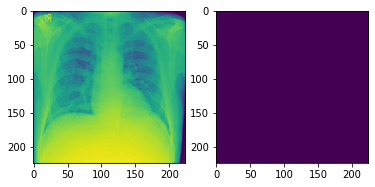

In [17]:
n = 25
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X_train_gen[n][0][0][:,:,0])
axarr[1].imshow(X_train_gen[n][1][0])

### Parameter list for the model

In [0]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [0]:
include_top = False
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
weights = "imagenet"
IMAGE_ORDERING = "channels_last"

### SegNet model with Mobilenet as backbone at encode level 3 i.e. after 5th Depthwise block



### [SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation](https://arxiv.org/pdf/1511.00561.pdf)

The architecture of the encoder network is topologically identical to the 13 convolutional layers in the
VGG16 network . The role of the decoder network is to map the low resolution encoder feature maps to full input resolution feature
maps for pixel-wise classification. The novelty of SegNet lies is in the manner in which the decoder upsamples its lower resolution input
feature map(s). Specifically, the decoder uses pooling indices computed in the max-pooling step of the corresponding encoder to
perform non-linear upsampling. This eliminates the need for learning to upsample. The upsampled maps are sparse and are then
convolved with trainable filters to produce dense feature maps.
![alt text](https://www.researchgate.net/publication/335600030/figure/fig1/AS:799251789533191@1567567884607/Illustration-of-Segnet-architecture-with-the-input-image-and-the-final-expected-output.jpg)

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def crop(o1, o2, i):
    o_shape2 = Model(i, o2).output_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height2 = o_shape2[2]
        output_width2 = o_shape2[3]
    else:
        output_height2 = o_shape2[1]
        output_width2 = o_shape2[2]

    o_shape1 = Model(i, o1).output_shape
    if IMAGE_ORDERING == 'channels_first':
        output_height1 = o_shape1[2]
        output_width1 = o_shape1[3]
    else:
        output_height1 = o_shape1[1]
        output_width1 = o_shape1[2]

    cx = abs(output_width1 - output_width2)
    cy = abs(output_height2 - output_height1)

    if output_width1 > output_width2:
        o1 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, 0),  (0, cx)),
                        data_format=IMAGE_ORDERING)(o2)

    if output_height1 > output_height2:
        o1 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o1)
    else:
        o2 = Cropping2D(cropping=((0, cy),  (0, 0)),
                        data_format=IMAGE_ORDERING)(o2)

    return o1, o2

def get_segmentation_model(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((IMAGE_HEIGHT, IMAGE_WIDTH)))(o)

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    

    return model

def mobile_model(trainable=True, n_up=3):
  
  model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=include_top, alpha=ALPHA, weights=weights)
  img_input = model.input
  for layer in model.layers:
    layer.trainable = trainable
    
    # f1 = model.get_layer("conv_pw_1_relu").output
    # f2 = model.get_layer("conv_pw_3_relu").output

    f3 = model.get_layer("conv_pw_5_relu").output

    # f4 = model.get_layer("conv_pw_11_relu").output
    # f5 = model.get_layer("conv_pw_13_relu").output
    

    # SEGNET encoder_level_3
    o = f3

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    for _ in range(n_up-2):
        o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
        o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
        o = (Conv2D(128, (3, 3), padding='valid',
             data_format=IMAGE_ORDERING))(o)
        o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(1, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)

    model = get_segmentation_model(img_input, o)
    model.model_name = "fcn_8"
  
  

  return model



### Create the model with frozen Mobilenet base layers

In [21]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = mobile_model(trainable=False)

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________________________________________________________

### Define metrics, loss and optimizers

In [0]:
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())#### Add your code here ####

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
#### Add your code here ####
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("checkpoint/model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model on the training set

In [41]:
batch_size = 4
model.fit(X_train_gen,
          epochs=3,
          workers = 1,
          steps_per_epoch = len(X_train_gen)/batch_size,
          validation_data=X_Val_gen,
          validation_steps = len(X_train_gen)/batch_size*2,
          callbacks= [checkpoint, reduce_lr, stop])

Epoch 1/3
1334/1334 [==============================] - ETA: 0s - loss: 40.8328 - dice_coefficient: 0.0107WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2668.0 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: loss improved from inf to 40.83278, saving model to checkpoint/model-40.83.h5
1334/1334 [==============================] - 8858s 7s/step - loss: 40.8328 - dice_coefficient: 0.0107 - val_loss: 41.8947 - val_dice_coefficient: 0.0113 - lr: 1.0000e-04
Epoch 2/3
1334/1334 [==============================] - ETA: 0s - loss: 40.7355 - dice_coefficient: 0.0109WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2668.0 batches). You may need to use the repeat() function when building yo

### Load the model from checkpoint for testing

In [0]:
WEIGHTS_FILE = "checkpoint/model-40.74.h5"
THRESHOLD = 0.8
EPSILON = 0.02

# model = create_model()
model = mobile_model()
model.load_weights(WEIGHTS_FILE)

### Create a test generator

In [0]:
test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)

### Prepare image for the model input

In [0]:
n = 0
sample_image = test_gen[n][0][0]
sample_image_redim = np.expand_dims(sample_image, axis=0)





### Pass image to the predict function

In [0]:
region = model.predict(sample_image_redim)

### Plot the image with ground truth mask and predicted mask.

Since the loaded model is trained for just 3 epochs, the predicted masks is not the accurate result we wish to obtain. Using different losses and with more training and hyperparameter tuning we can achieve the desired results.

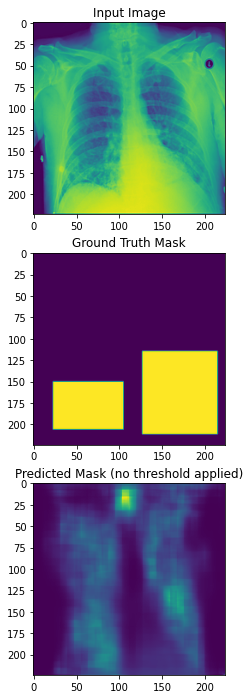

In [90]:
f, (ax1,ax2,ax3) = plt.subplots(3)
f.set_figheight(12)
f.set_figwidth(12)
ax1.set_title('Input Image')
ax1.imshow(sample_image[:,:,0])
ax2.set_title('Ground Truth Mask')
ax2.imshow(test_gen[n][1][0])
ax3.set_title('Predicted Mask (no threshold applied)')
ax3.imshow(region[0])


# Conclusion
* We created a custom data generator to load the X-Rays images as well as corresponding target masks.
* Using Mobilenet model as encoder and SegNet as decoder we created a model for image segmentation to predict the region of condtion for pneumonia.
* We use dice co-efficient as a metric while training to measure the similarity between data

# To do
1. To improve model performance:
* Train model for more epochs
* Tune Hyperparameters
* Try different losses

2. Implement other image segmentation architectures
3. Implement ChexNet architecture